In [1]:
%run ../../base-notebook.ipynb

TensorFlow version: 2.12.0
TensorFlow-Text version: 2.12.0
Python version 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:41:52) [Clang 15.0.7 ]


In [2]:
import so_ml_tools as soml

import tensorflow as tf
import matplotlib.pyplot as plt

from keras import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Dense, RandomFlip, RandomZoom, RandomHeight, \
    RandomWidth, RandomRotation, Input, GlobalAveragePooling2D
from keras.losses import categorical_crossentropy
from keras.utils import image_dataset_from_directory

## Transfer learning with TensorFlow Part 3: Scaling up (Food vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging our power of deep learning).

## 101 Food Classes: working with less data

The data we're downloading comes from the origial food 101-dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [3]:
soml.util.io.download_file(source='https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip', filepath='./101_food_classes_10_percent.zip')
soml.util.io.extract_zip(filepath='./101_food_classes_10_percent.zip', folder='./data')

train_dir = './data/101_food_classes_10_percent/train'
test_dir = './data/101_food_classes_10_percent/test'

Download of https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip completed.


In [4]:
soml.util.io.list_dir_summary(folder='./data/101_food_classes_10_percent')

There are 2 directories, and 0 in ./data/101_food_classes_10_percent
There are 101 directories, and 0 in ./data/101_food_classes_10_percent/test
There are 0 directories, and 250 in ./data/101_food_classes_10_percent/test/foie_gras
There are 0 directories, and 250 in ./data/101_food_classes_10_percent/test/club_sandwich
There are 0 directories, and 250 in ./data/101_food_classes_10_percent/test/cheese_plate
There are 0 directories, and 250 in ./data/101_food_classes_10_percent/test/cup_cakes
There are 0 directories, and 250 in ./data/101_food_classes_10_percent/test/garlic_bread
There are 0 directories, and 250 in ./data/101_food_classes_10_percent/test/gnocchi
There are 0 directories, and 250 in ./data/101_food_classes_10_percent/test/ice_cream
There are 0 directories, and 250 in ./data/101_food_classes_10_percent/test/samosa
There are 0 directories, and 250 in ./data/101_food_classes_10_percent/test/donuts
There are 0 directories, and 250 in ./data/101_food_classes_10_percent/test/tun

In [5]:
# Setup data inputs
IMG_SIZE = (224, 224)

train_data_all_10_percent = image_dataset_from_directory(directory=train_dir,
                                                         label_mode='categorical',
                                                         image_size=IMG_SIZE,
                                                         batch_size=32)

test_data_all_10_percent = image_dataset_from_directory(directory=test_dir,
                                                         label_mode='categorical',
                                                         image_size=IMG_SIZE,
                                                         batch_size=32,
                                                         shuffle=False) # Don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Metal device set to: Apple M1 Max
Found 25250 files belonging to 101 classes.


# Train a big dog model with transfer learning on 10% of 101 Food classes.

Here are the steps we are going to do first.
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [6]:
# Create checkpoint fallback
model_checkpoint_callback = soml.tf.model.callback.model_checkpoint_callback(
    experiment_name="101_classes_10_percent_data_model_checkpoint",
    save_weights_only=True,
    metric='val_accuracy',
    save_best_only=True)

In [7]:
# Create data augmentation layer
data_augementation_layer = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(.2),
    RandomHeight(.2),
    RandomWidth(.2),
    RandomZoom(.2),
    # Rescaling(1/255.) # Only neccesary for some models, but not for EfficientNetB0, But neccesary for ResNet50V2
], name="data_augmentation")

In [8]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable layers on top
input_layer = Input(shape=IMG_SIZE + (3,), name="input_layer")
x = data_augementation_layer(input_layer) # Augment images
x = base_model(x, training=False) # Put the base model in inference mode so weights need to stay frozen
x = GlobalAveragePooling2D(name="global_average_pooling_2d")(x)
output_layer = Dense(len(train_data_all_10_percent.class_names), name="output_layer", activation="softmax")(x)

model = Model(input_layer, output_layer)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_2d (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [10]:
# Compile the model
model.compile(loss=categorical_crossentropy,
                optimizer=Adam(),
                metrics=["accuracy"])

In [11]:
# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           steps_per_epoch=len(train_data_all_10_percent),
                                           epochs=5,
                                           validation_data=test_data_all_10_percent,
                                           validation_steps=int(0.15 * len(test_data_all_10_percent)), # Validate on only 15% of test data
                                           callbacks=[model_checkpoint_callback])

Epoch 1/5


2023-09-01 20:43:33.123283: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


237/237 [==============================] - ETA: 0s - loss: 3.5222 - accuracy: 0.2343
Epoch 1: val_accuracy improved from -inf to 0.41393, saving model to ./checkpoints/101_classes_10_percent_data_model_checkpoint/model-epoch-01-val_accuracy-0.41.hdf5
237/237 [==============================] - 165s 679ms/step - loss: 3.5222 - accuracy: 0.2343 - val_loss: 2.6718 - val_accuracy: 0.4139
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.4314 - accuracy: 0.4462
Epoch 2: val_accuracy improved from 0.41393 to 0.49921, saving model to ./checkpoints/101_classes_10_percent_data_model_checkpoint/model-epoch-02-val_accuracy-0.50.hdf5
237/237 [==============================] - 236s 996ms/step - loss: 2.4314 - accuracy: 0.4462 - val_loss: 2.1536 - val_accuracy: 0.4992
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 2.0461 - accuracy: 0.5162
Epoch 3: val_accuracy improved from 0.49921 to 0.50900, saving model to ./checkpoints/101_classes_10_percent_data_model_

In [12]:
fine_tuning_results = model.evaluate(test_data_all_10_percent)
fine_tuning_results

790/790 [==============================] - 532s 674ms/step - loss: 1.6409 - accuracy: 0.5682


[1.6408926248550415, 0.568198025226593]

In [ ]:
soml.tf.model.plot.plot_history(history=history_all_classes_10_percent)

Seems to be overfitting, the validation accuracy is flattening but the training accuracy is still increasing.

## Fine-tuning

In [14]:
# Unfreeze all of the layers in the baseline.
base_model.trainable = False

soml.tf.model.layer.set_trainable_on_last_n_layers(model=base_model, n=5, trainable=True)

soml.tf.model.layer.list_model(model=base_model)

row   | name (type)                                         | dtype   | policy  | trainable | output shape
0     | input_1                    (InputLayer            ) | float32 | float32 | False     | [(None, None, None, 3)] 
1     | rescaling                  (Rescaling             ) | float32 | float32 | False     | (None, None, None, 3)   
2     | normalization              (Normalization         ) | float32 | float32 | False     | (None, None, None, 3)   
3     | stem_conv                  (Conv2D                ) | float32 | float32 | False     | (None, None, None, 32)  
4     | stem_bn                    (BatchNormalization    ) | float32 | float32 | False     | (None, None, None, 32)  
5     | stem_activation            (Activation            ) | float32 | float32 | False     | (None, None, None, 32)  
6     | block1a_project_conv       (Conv2D                ) | float32 | float32 | False     | (None, None, None, 16)  
7     | block1a_project_bn         (BatchNormalization    ) 

In [15]:
# Recompile model with lower learning rate
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [16]:
# Fine tune for 5 more epochs.

fine_tune_epochs = 10 # Model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (feature extraction is 5, fine-tune is 5 so 10 in total


history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     steps_per_epoch=len(train_data_all_10_percent),
                                                     epochs=fine_tune_epochs,
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1] + 1,
                                                     validation_data=test_data_all_10_percent,
                                                     validation_steps=int(0.15 * len(test_data_all_10_percent)))

Epoch 6/10
 91/237 [==========>...................] - ETA: 10:02 - loss: 1.5537 - accuracy: 0.6253

KeyboardInterrupt: 

In [ ]:
all_classes_10_percent_fine_tune_results = model.evaluate(test_data_all_10_percent)
all_classes_10_percent_fine_tune_results

In [ ]:
soml.tf.model.plot.plot_consecutive_histories(histories=[history_all_classes_10_percent,history_all_classes_10_percent_fine_tune], labels=["base", "fine-tune"] )

## Saving and loading our model

To use our model in an external application we'll need to save it and export it somewhere.

In [19]:
# Save our fine tuned model
model.save("./models/101_food_classes_10_percent_saved_big_dog_model", save_format="h5")

# This will fail, due to a bug that is still present in TF version 2.12.0

In [20]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("./models/101_food_classes_10_percent_saved_big_dog_model")

In [21]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_result = loaded_model.evaluate(test_data_all_10_percent)
loaded_model_result

790/790 [==============================] - 68s 82ms/step - loss: 1.5767 - accuracy: 0.5846


[1.5766949653625488, 0.5846336483955383]

In [22]:
# The results from our loaded model (above) should be very similar to the results below.
all_classes_10_percent_fine_tune_results

[1.5766949653625488, 0.5846336483955383]

In [23]:
soml.util.io.download_file(source='https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip', filepath='./06_101_food_class_10_percent_saved_big_dog_model.zip')
soml.util.io.extract_zip(filepath='./06_101_food_class_10_percent_saved_big_dog_model.zip')
model = tf.keras.models.load_model('./data/06_101_food_class_10_percent_saved_big_dog_model')

In [24]:
loaded_accuracy = model.evaluate(test_data_all_10_percent)

790/790 [==============================] - 62s 76ms/step - loss: 1.8027 - accuracy: 0.6078


In [34]:
loaded_accuracy

[1.8027204275131226, 0.6077623963356018]

In [25]:
# Make predictions with model
pred_probs = model.predict(test_data_all_10_percent, verbose=1) # set verbosity to see how long it will take 

790/790 [==============================] - 64s 77ms/step


In [26]:
# How many predictions are there?
len(pred_probs)

25250

In [27]:
# What's the shape of our predictions?
pred_probs.shape

(25250, 101)

In [28]:
# How do they look?
pred_probs[:10]

array([[5.9542250e-02, 3.5742164e-06, 4.1377187e-02, ..., 1.4138726e-09,
        8.3530780e-05, 3.0897551e-03],
       [9.6401691e-01, 1.3753301e-09, 8.4780622e-04, ..., 5.4286953e-05,
        7.8362074e-12, 9.8466224e-10],
       [9.5925868e-01, 3.2533739e-05, 1.4866976e-03, ..., 7.1891338e-07,
        5.4397526e-07, 4.0275998e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805575e-03, ..., 5.9749855e-04,
        6.6969078e-05, 2.3469336e-05],
       [4.4571787e-02, 4.7265317e-07, 1.2258493e-01, ..., 6.3498283e-06,
        7.5318690e-06, 3.6778722e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [29]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.95422499e-02 3.57421641e-06 4.13771868e-02 1.06605680e-09
 8.16142265e-09 8.66399219e-09 8.09274582e-07 8.56526867e-07
 1.98591733e-05 8.09777873e-07 3.17277227e-09 9.86742407e-07
 2.85322807e-04 7.80494447e-10 7.42302567e-04 3.89163870e-05
 6.47404477e-06 2.49773825e-06 3.78912555e-05 2.06783156e-07
 1.55384569e-05 8.15072838e-07 2.62307503e-06 2.00107493e-07
 8.38279675e-07 5.42160024e-06 3.73910780e-06 1.31505740e-08
 2.77615967e-03 2.80519544e-05 6.85622448e-10 2.55749364e-05
 1.66889979e-04 7.64073860e-10 4.04531223e-04 1.31507001e-08
 1.79573817e-06 1.44482760e-06 2.30628420e-02 8.24669542e-07
 8.53656331e-07 1.71387171e-06 7.05256616e-06 1.84021545e-08
 2.85534099e-07 7.94837069e-06 2.06816003e-06 1.85251395e-07
 3.36199406e-08 3.15226236e-04 1.04109558e-05 8.54483915e-07
 8.47418129e-01 1.05554591e-05 4.40948469e-07 3.74041920e-05
 3.53062715e-05 3.24890498e-05 6.73150862e-

In [30]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = soml.tf.dataset.get_labels(dataset=test_data_all_10_percent)

In [32]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes

array([ 52,   0,   0, ..., 100,  94, 100])

In [33]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6077623762376237

In [36]:
# Does the evaluate method compare to the Scikit-Learn measured accuracy?
import numpy as np

# Remember the loaded_accurac consists of two values, second value is the accuracy.
print(f"Close? {np.isclose(loaded_accuracy[1], sklearn_accuracy)} | Difference: {loaded_accuracy[1] - sklearn_accuracy}")

Close? True | Difference: 2.0097978059574473e-08


In [39]:
# Get the class names
class_names = test_data_all_10_percent.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [41]:
soml.multiclass.plot.confusion_matrix(y_true=y_labels, y_pred=pred_probs, class_names=class_names, figsize=(100, 100), text_size=20)

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called classifiction report.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels, y_pred=pred_classes, target_names=class_names))

                         precision    recall  f1-score   support

              apple_pie       0.29      0.20      0.24       250
         baby_back_ribs       0.51      0.69      0.59       250
                baklava       0.56      0.65      0.60       250
         beef_carpaccio       0.74      0.53      0.62       250
           beef_tartare       0.73      0.43      0.54       250
             beet_salad       0.34      0.54      0.42       250
               beignets       0.67      0.79      0.72       250
               bibimbap       0.82      0.76      0.79       250
          bread_pudding       0.40      0.37      0.39       250
      breakfast_burrito       0.62      0.44      0.51       250
             bruschetta       0.62      0.42      0.50       250
           caesar_salad       0.84      0.49      0.62       250
                cannoli       0.52      0.74      0.61       250
          caprese_salad       0.56      0.60      0.58       250
            carrot_cake 

The numbers above give a greate class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

Let's visualize the data.

## Let's plot all of our classes F1-scores...

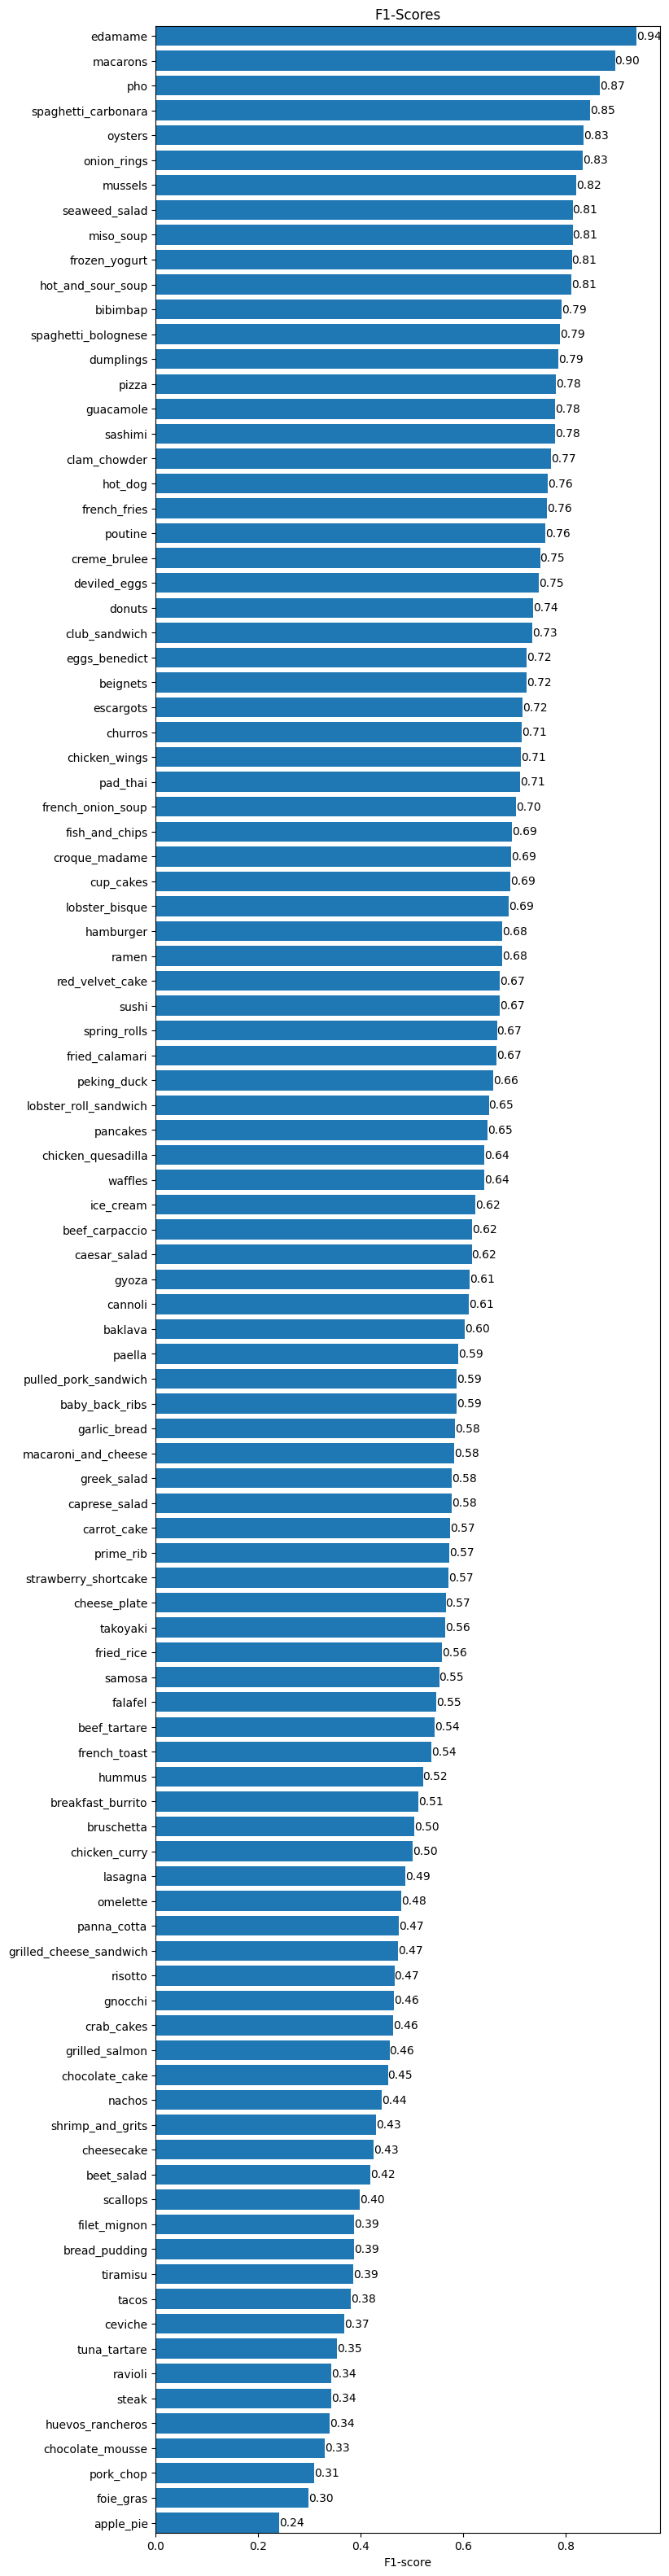

In [43]:
soml.multiclass.plot.f1_score_chart(y_true=y_labels, y_pred=pred_probs, class_names=class_names, figsize=(8,40))

## Visualizing predictions on custom images

Now, this is the real test, how does our model go on food images not even in our test dataset (images of our own)

To visualize our model's predictions on our own images we'l need a function to load and preprocess images, specifically it will need to:
* Read in a target image filepath using t.f.io.read_file_path
* Turn the image into a Tensor using tf.io.decode_image
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.rezise()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [44]:
# See function definition in mli.load_image_as_tensor

Now we've got our function to load and prepare target images, let's now write some code to visualize inmages, their target label and our model's predictions.

Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probability and truth label

1/1 [==============================] - 0s 27ms/step


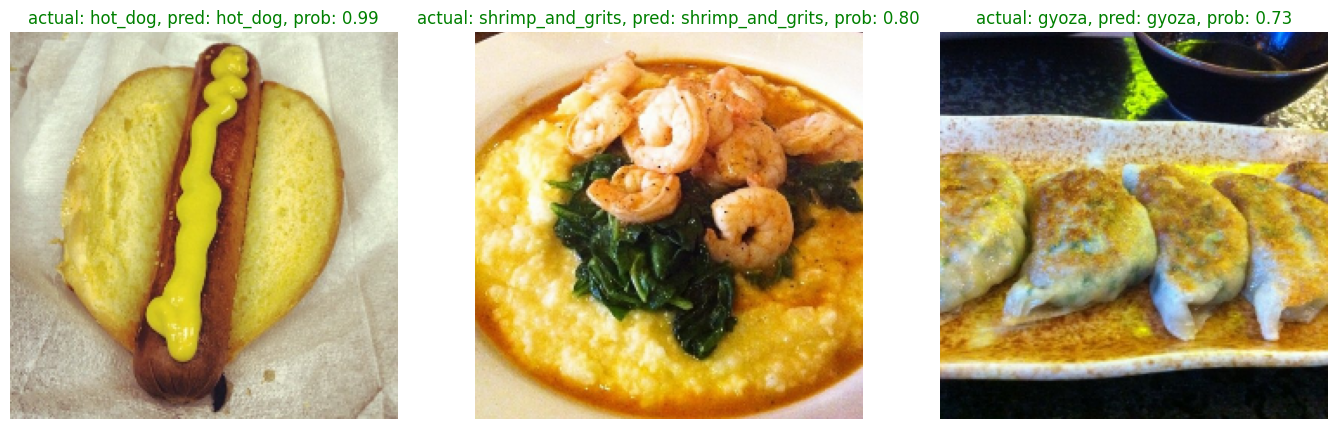

In [47]:
# Make preds on a series of images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(os.path.join(test_dir, class_name)))
  filepath = os.path.join(test_dir, class_name, filename)
  
  # Load the image and make predictions
  img = soml.util.io.load_image_as_tensor(filename=filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # Get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # Get highest probability index
  
  # Plot images
  rows = 1
  cols = 3
  plt.subplot(rows, cols, i+1)
  plt.imshow(img)
  if class_name == pred_class: # If predicted class matches true class make tekst green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False)


## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using list_files() method.
2. Create a pandas DataFrame of the image filepaths, grund truth labels, predicted classes (from our model), max predictions probabilities, ground truth class names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn';t math the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top)./
5. Visualize the images with the highest prediction probabilities but have the wrong predction.

In [48]:
# Get all of the image file paths in the test dataset.
import os

filepaths = []
for filepath in test_data_all_10_percent.list_files(os.path.join(test_dir, '*', '*.jpg'), shuffle=False):
  filepaths.append(filepath.numpy())

filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [49]:
import pandas as pd
pred_pd = pd.DataFrame({"image_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1),
                        "y_true_classname" : [class_names[i] for i in y_labels],
                        "y_pred_classn": [class_names[i] for i in pred_classes]})

pred_pd

image_path  y_true  y_pred  \
0      b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3      b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4      b'101_food_classes_10_percent/test/apple_pie/1...       0      79   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent/test/waffles/942...     100     100   
25246  b'101_food_classes_10_percent/test/waffles/954...     100      16   
25247  b'101_food_classes_10_percent/test/waffles/961...     100     100   
25248  b'101_food_classes_10_percent/test/waffles/970...     100      94   
25249  b'101_food_classes_10_percent/test/waffles/971...     100     100   

       pred_conf y_true_classname         y_pred_classn  
0       0.847418        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658607        apple_pie  pulled_pork_sandwich  
4       0.367901        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878028          waffles          cheese_plate  
25247   0.537899          waffles               waffles  
25248   0.501949          waffles  strawberry_shortcake  
25249   0.690628          waffles               waffles  

[25250 rows x 6 columns]

In [50]:
# 3. Find out in our DataFrame which predictions are wrong
pred_pd["pred_correct"] = pred_pd["y_true"] == pred_pd["y_pred"]
pred_pd.head()

image_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      79   

   pred_conf y_true_classname         y_pred_classn  pred_correct  
0   0.847418        apple_pie                 gyoza         False  
1   0.964017        apple_pie             apple_pie          True  
2   0.959259        apple_pie             apple_pie          True  
3   0.658607        apple_pie  pulled_pork_sandwich         False  
4   0.367901        apple_pie             prime_rib         False

In [51]:
# 4. Sort our dataframe to have most wrong predictions at the top.
pred_pd_top_100 = pred_pd[pred_pd["pred_correct"] == False ].sort_values("pred_conf", ascending=False)[:100]
pred_pd_top_100

image_path  y_true  y_pred  \
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
231    b'101_food_classes_10_percent/test/apple_pie/8...       0     100   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
23539  b'101_food_classes_10_percent/test/strawberry_...      94      83   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85      92   
...                                                  ...     ...     ...   
8763   b'101_food_classes_10_percent/test/escargots/1...      35      41   
2663   b'101_food_classes_10_percent/test/bruschetta/...      10      61   
7924   b'101_food_classes_10_percent/test/donuts/3454...      31      29   
18586  b'101_food_classes_10_percent/test/peking_duck...      74      39   
3519   b'101_food_classes_10_percent/test/carrot_cake...      14      21   

       pred_conf       y_true_classname          y_pred_classn  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
...          ...                    ...                    ...           ...  
8763    0.997169              escargots      french_onion_soup         False  
2663    0.997055             bruschetta  lobster_roll_sandwich         False  
7924    0.997020                 donuts              cup_cakes         False  
18586   0.996885            peking_duck              foie_gras         False  
3519    0.996842            carrot_cake         chocolate_cake         False  

[100 rows x 7 columns]

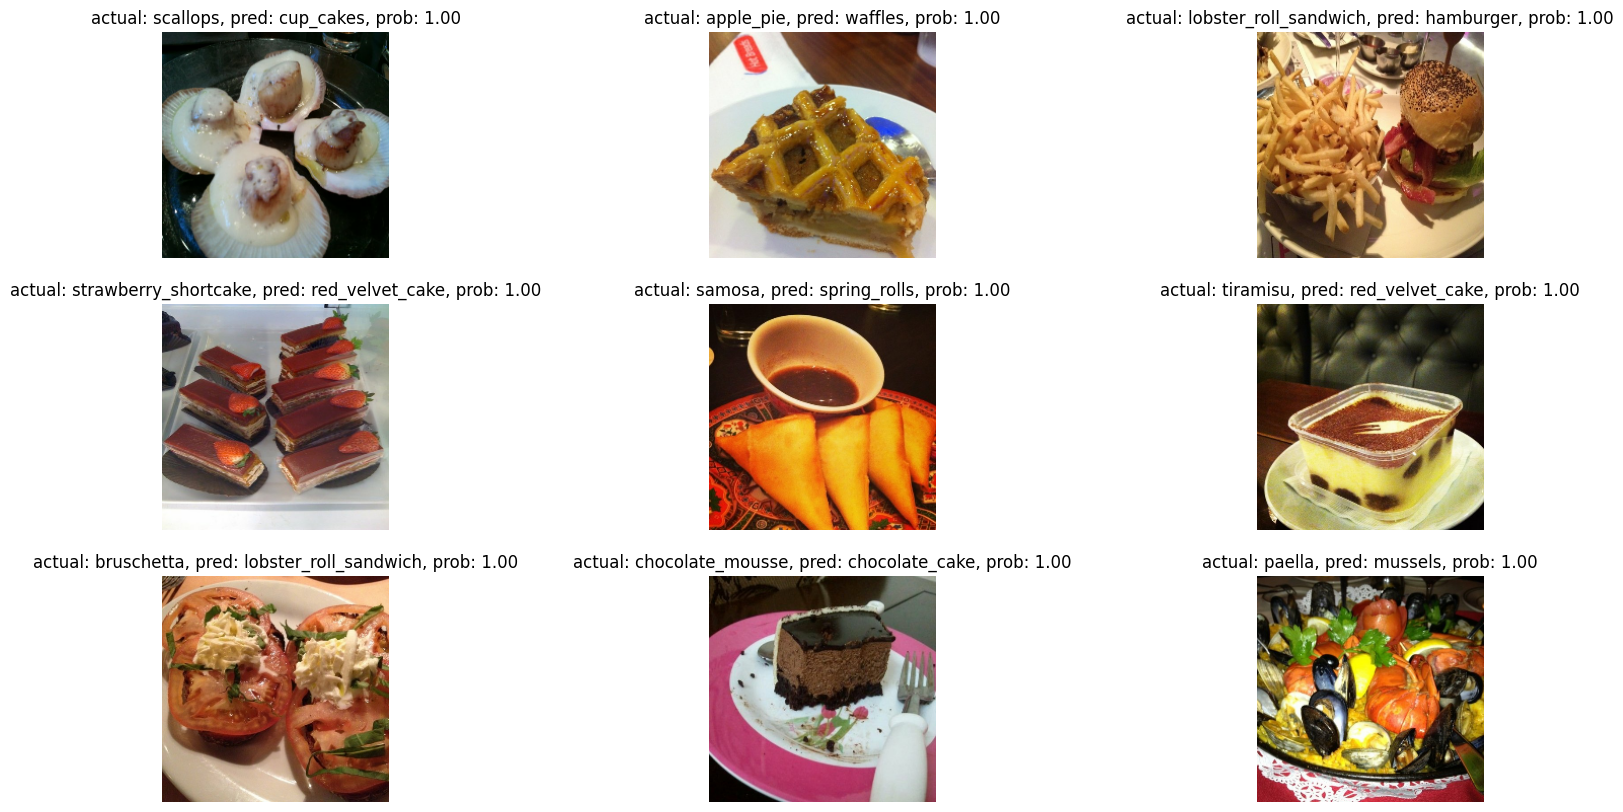

In [52]:
# 5. Visualize the test data samples which have the wrong prediction but highes pred probability.
# Make preds on a series of images
images_to_view = 9
start_index = 0
plt.figure(figsize=(20, 10))
for i, row in enumerate(pred_pd_top_100[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = soml.util.io.load_image_as_tensor(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # Only interested in a few parameters of each row.
  plt.imshow(img)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname}, prob: {pred_prob:.2f}")
  plt.axis(False)

## Test out the big dog model on our own custom images

In [53]:
# Get custom images
soml.util.io.download_file(source='https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip',
                  filepath='custom_food_images.zip')
soml.util.io.extract_zip(filepath='custom_food_images.zip')
soml.util.io.list_dir_summary(folder='custom_food_images')

There are 0 directories, and 6 in custom_food_images


In [54]:
# Get the custom food images file path
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("/content/custom_food_images")]
custom_food_images

['custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/steak.jpeg']

1/1 [==============================] - 0s 36ms/step


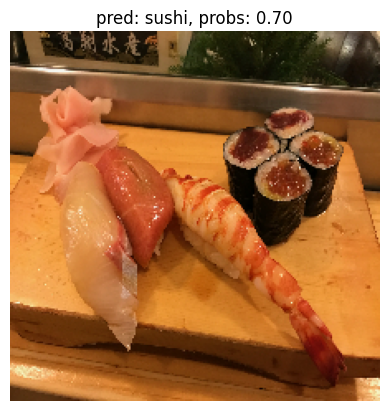

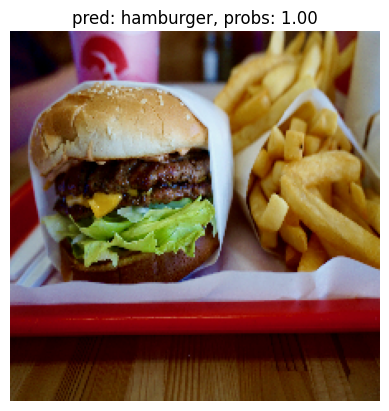

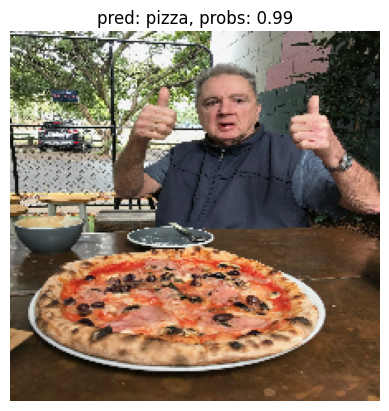

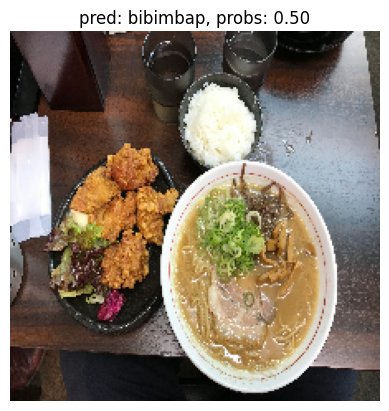

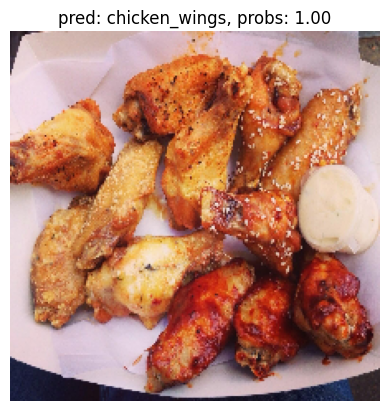

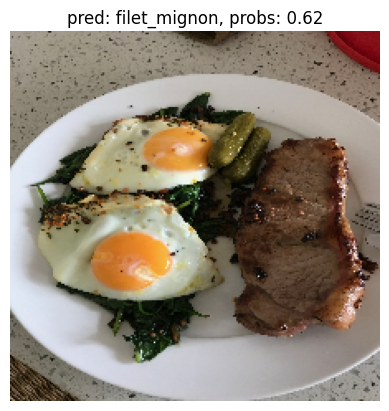

In [55]:
# Make and plot custom food images
for filename in custom_food_images:
  img = soml.util.io.load_image_as_tensor(filename, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # Make prediction on image with shape [1, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # Get the index with the highest probability
  # Plot the appropriate information
  plt.figure()
  plt.imshow(img)
  plt.title(f"pred: {pred_class}, probs: {pred_prob.max():.2f}")
  plt.axis(False)




## Assignment: Perform first model but with mixed_precision enabled

In [57]:
from keras import mixed_precision
from keras.layers import Activation

# Configure system to use mixed-precision
policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)

# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable layers on top
input_layer = Input(shape=IMG_SIZE + (3,), name="input_layer")
x = data_augementation_layer(input_layer) # Augment images
x = base_model(x, training=False) # Put the base model in inference mode so weights need to stay frozen
x = GlobalAveragePooling2D(name="global_average_pooling_2d")(x)

# Very important, when using mixed precision, make sure the activation is done seperatly especially on
# the last layer.
#
# see: https://www.tensorflow.org/guide/mixed_precision
x = Dense(len(train_data_all_10_percent.class_names), name="output_layer")(x)
output_layer = Activation('softmax', dtype='float32')(x)

model = Model(input_layer, output_layer)

# Compile the model
model.compile(loss=categorical_crossentropy,
                optimizer=Adam(),
                metrics=["accuracy"])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_2d (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                           

In [58]:
# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           steps_per_epoch=len(train_data_all_10_percent),
                                           epochs=5,
                                           validation_data=test_data_all_10_percent,
                                           validation_steps=int(0.15 * len(test_data_all_10_percent)), # Validate on only 15% of test data
                                           callbacks=[model_checkpoint_callback])

Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.5204 - accuracy: 0.2350
Epoch 1: val_accuracy did not improve from 0.53972
237/237 [==============================] - 124s 482ms/step - loss: 3.5204 - accuracy: 0.2350 - val_loss: 2.6249 - val_accuracy: 0.4333
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.4348 - accuracy: 0.4432
Epoch 2: val_accuracy did not improve from 0.53972
237/237 [==============================] - 94s 397ms/step - loss: 2.4348 - accuracy: 0.4432 - val_loss: 2.1891 - val_accuracy: 0.4860
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 2.0480 - accuracy: 0.5163
Epoch 3: val_accuracy did not improve from 0.53972
237/237 [==============================] - 77s 321ms/step - loss: 2.0480 - accuracy: 0.5163 - val_loss: 1.9555 - val_accuracy: 0.5212
Epoch 4/5
237/237 [==============================] - ETA: 0s - loss: 1.8352 - accuracy: 0.5531
Epoch 4: val_accuracy did not improve from 0.53972
237/237 [====

In [59]:
# Evaluate teh model                                           
mixed_precision_results = model.evaluate(test_data_all_10_percent)
mixed_precision_results

790/790 [==============================] - 64s 81ms/step - loss: 1.6265 - accuracy: 0.5731


[1.6264780759811401, 0.5731484889984131]

In [60]:
# compare with fine tuning results
fine_tuning_results

[1.6216118335723877, 0.5740990042686462]

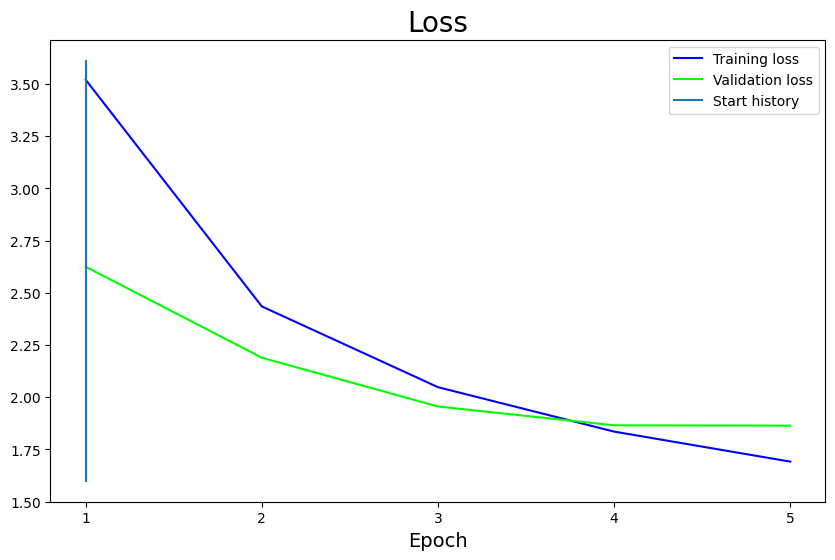

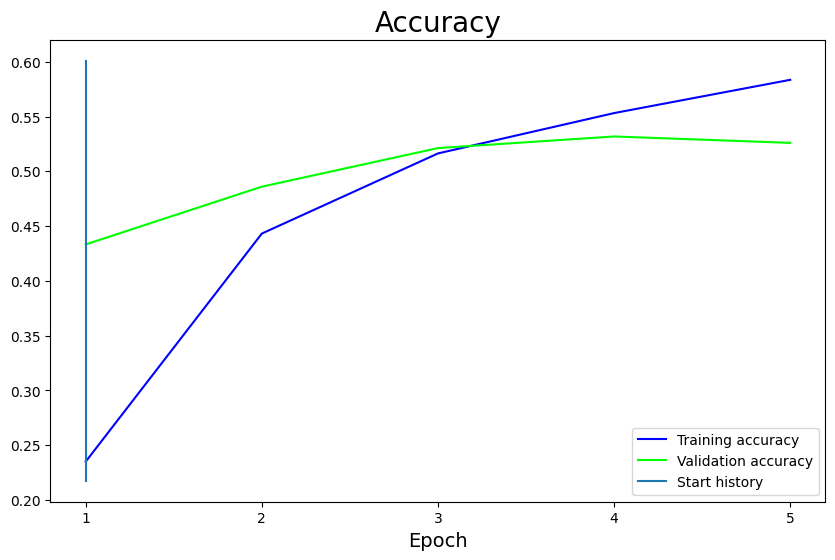

In [61]:
soml.tf.model.plot.plot_history(history=history_all_classes_10_percent)